# Classification K-mean
1. Ouverture / visualisation des images
2. Optimisation de K
3. Application du K-means
4. classification des clusters
5. segmentation

## 1. Ouverture / visualisation des images


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from keras.models import load_model
from PIL import Image, ImageOps
import os
import cv2 as cv
import natsort

2022-07-18 15:59:56.303574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 15:59:56.303594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Ouverture des images étudiées

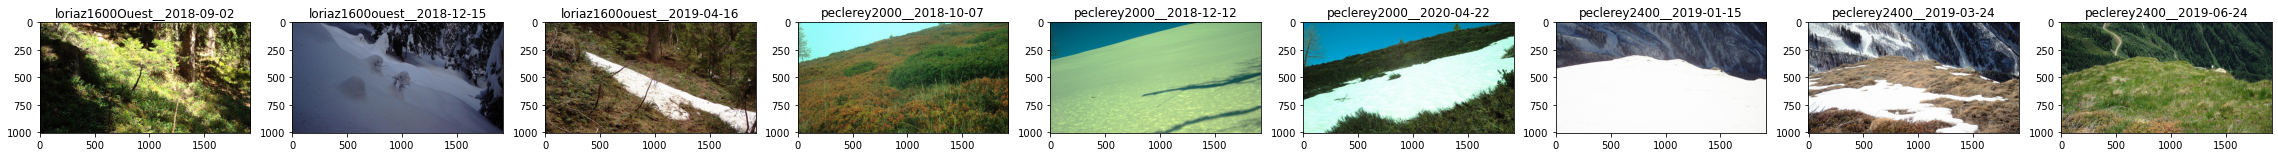

In [2]:
dir  = os.getcwd()
dir,__ = os.path.split(dir)
imgs_path = os.listdir(dir + '/data/Ref/Imgs')
imgs_path.sort()

imgs = []
for i in imgs_path:
    imgs += [imread(f"{dir}/data/Ref/Imgs/{i}")]

fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(imgs_path[i][:-17])
plt.show()

#### mise en forme des données pour l'application du K-means


In [3]:
def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
    return df
# 6 minutes pour 9 images

df_imgs = []
for img in imgs:
    df_img = image_to_pandas(img)
    df_img.head(5)
    df_imgs.append(df_img)

## 2. Optimisation de K

### Recherche du nombre optimal de classes
The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

When the distortions are plotted and the plot looks like an arm then the “elbow”(the point of inflection on the curve) is the best value of k.
Nombre de points de départ aléatoires = 42

In [4]:
# Application du K-means sur k classes
# temps estimé: 50 secondes /image soit 8 min au total
distortionsList = [] # contient les distortions correspondant à chaque images
K = range(1,10)

for df in df_imgs:
    distortions = []

    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
        
    distortionsList.append(distortions)

Visualisation de l'effet du nombre de classes

Loriaz 1600
_nolegend_
_nolegend_
Peclerey 2000
_nolegend_
_nolegend_
Peclerey 2400
_nolegend_
_nolegend_


/tmp/ipykernel_150413/1649541264.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, dist, 'bx-', color = col, label=leg)


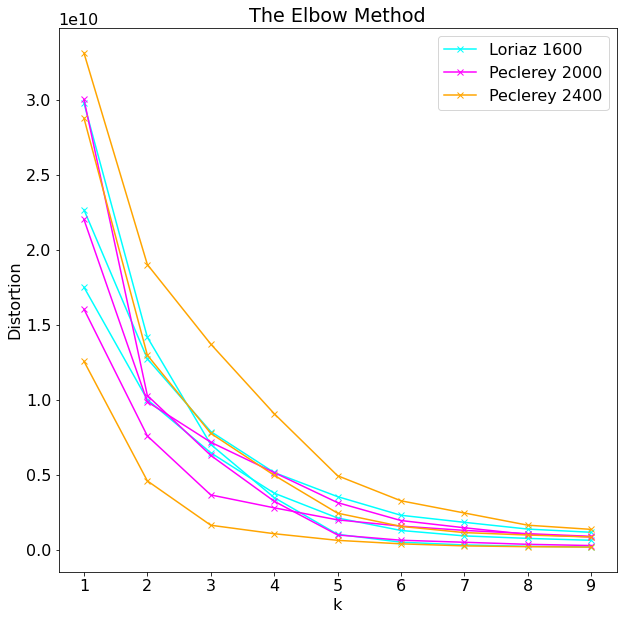

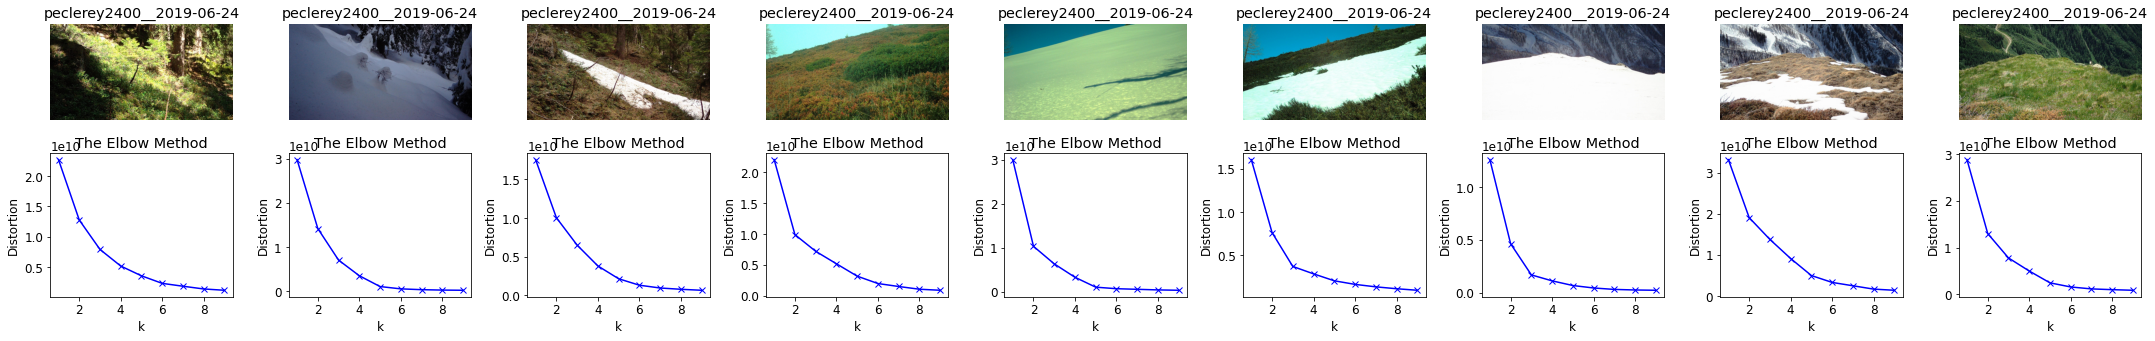

In [5]:
legends = ['Loriaz 1600','_nolegend_','_nolegend_', 'Peclerey 2000','_nolegend_','_nolegend_', 'Peclerey 2400','_nolegend_','_nolegend_']
couleur = ['cyan','cyan','cyan', 'magenta','magenta','magenta', 'orange','orange','orange']

# résultat par zones
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 10))
for dist, col, leg in zip(distortionsList, couleur, legends):
    plt.plot(K, dist, 'bx-', color = col, label=leg)
    print(leg)
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method')
plt.legend()
plt.show()

# détails par image
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, len(imgs), figsize = (30, 5))
for row in range(len(imgs)):
    axs[0][row].imshow(imgs[row])
    axs[0][row].set_title(imgs_path[i][:-17])
    axs[0][row].set_axis_off()
    axs[1][row].plot(K, distortionsList[row], 'bx-')
    axs[1][row].set_xlabel('k')
    axs[1][row].set_ylabel('Distortion')
    axs[1][row].set_title('The Elbow Method')
plt.tight_layout()
plt.show()

Un bon compromis consiste à fixer le nombre de classes à 5

## 3. Application du K-means

Réalisation du K-means

In [6]:
clusters = [] # contient les clusters correspondants à chaque image
results = []
n_clusters =  5

for row in range(len(imgs)):
    tempCluster = []
    kmeans = KMeans(n_clusters, random_state = 10).fit(df_imgs[row])
    result = kmeans.labels_.reshape(imgs[row].shape[0],imgs[row].shape[1])
    results.append(result)

Visualisation des clusters (non classifiés) résultants

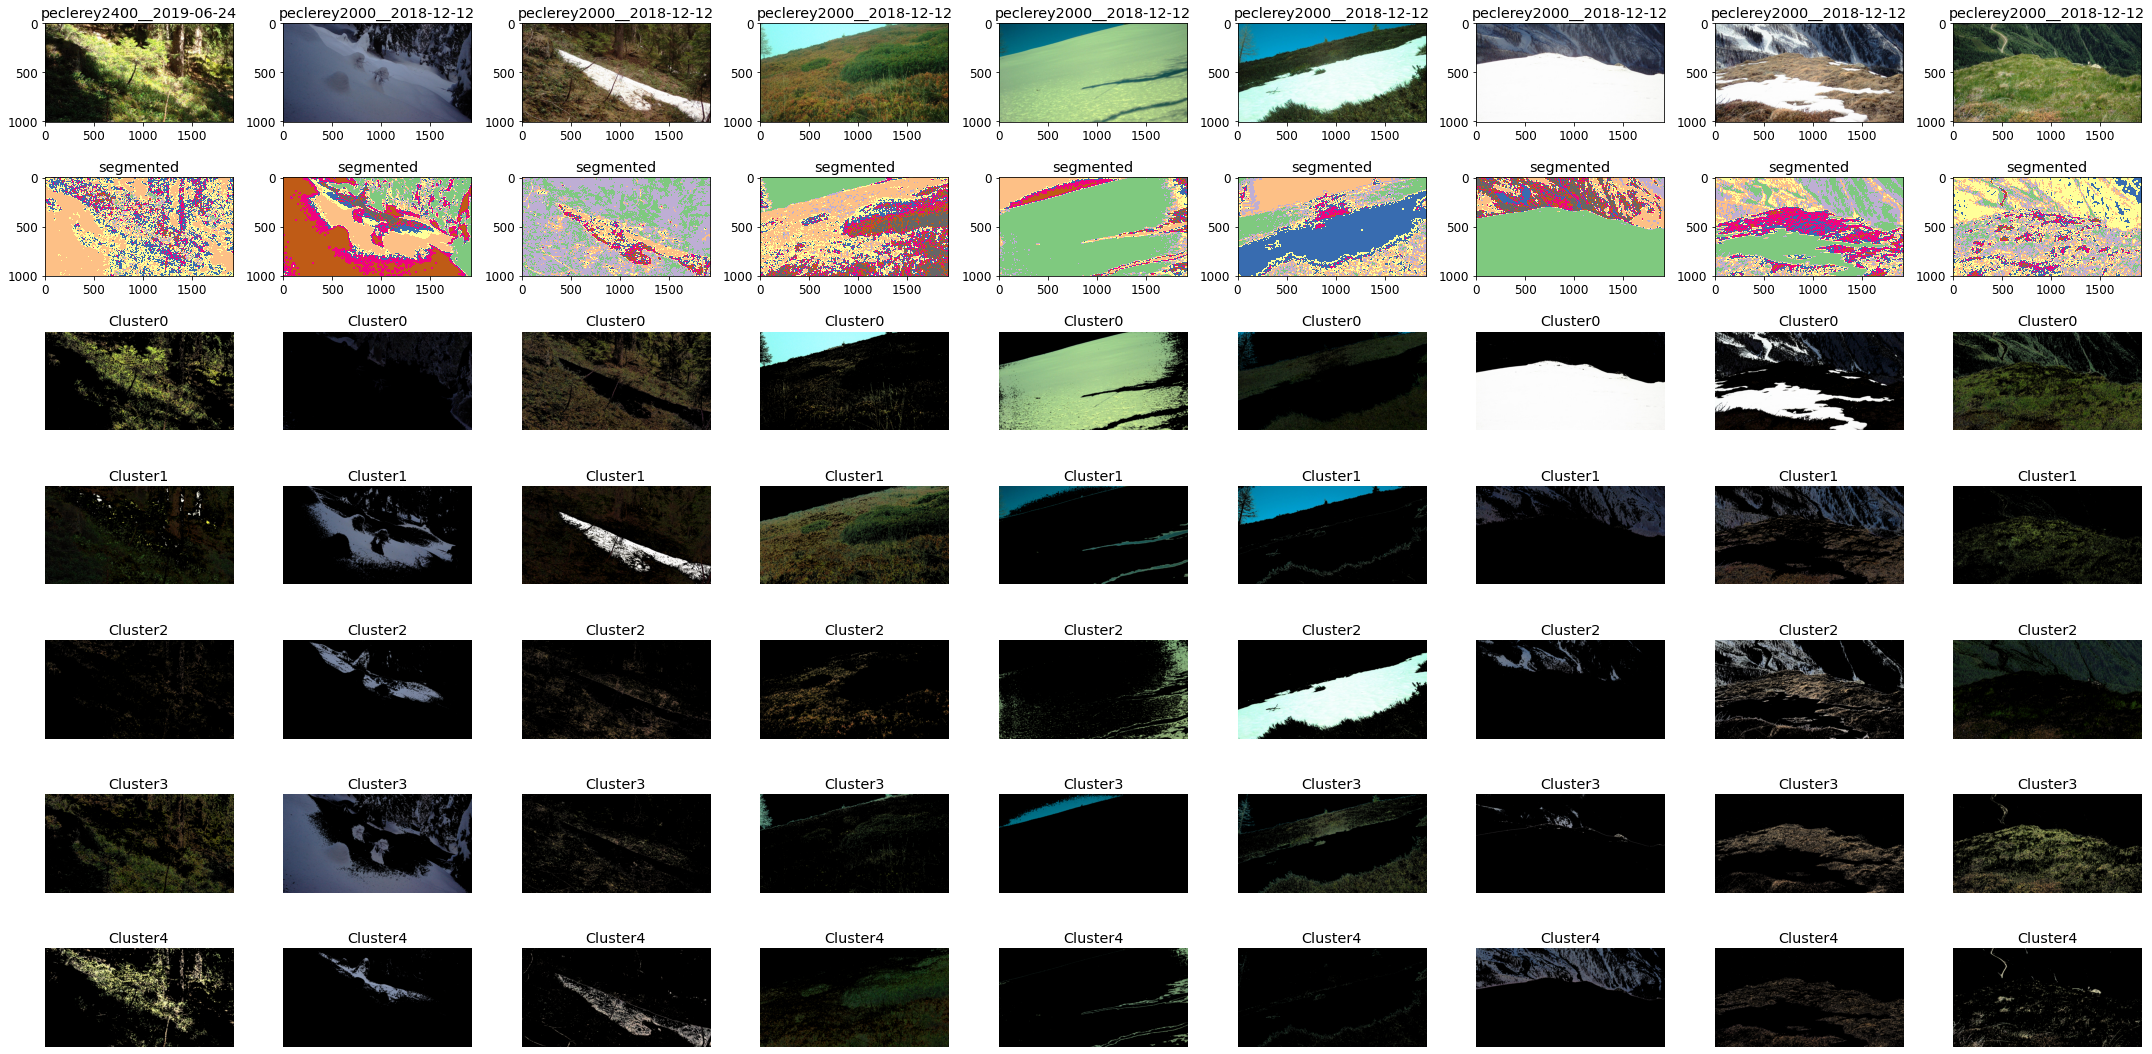

In [7]:
resultImgs = []
fig, axs = plt.subplots(2+n_clusters, len(imgs), figsize = (30, 15))
for row in range(len(imgs)):

    axs[0][row].imshow(imgs[row])
    axs[0][row].set_title(imgs_path[i][:-17])
    axs[1][row].imshow(results[row], cmap='Accent')
    axs[1][row].set_title('segmented')
    for i in range(n_clusters):
        tempImg = imgs[row].copy()
        tempImg[:, :, 0] = tempImg[:, :, 0]*(results[row]==[i])
        tempImg[:, :, 1] = tempImg[:, :, 1]*(results[row]==[i])
        tempImg[:, :, 2] = tempImg[:, :, 2]*(results[row]==[i])
        axs[i+2][row].imshow(tempImg)
        axs[i+2][row].set_title(f'Cluster{i}')
        axs[i+2][row].set_axis_off()
        resultImgs.append(tempImg)
plt.tight_layout()
plt.show()

### Classification

liste des labels : ['avecNeige', 'sansNeige']


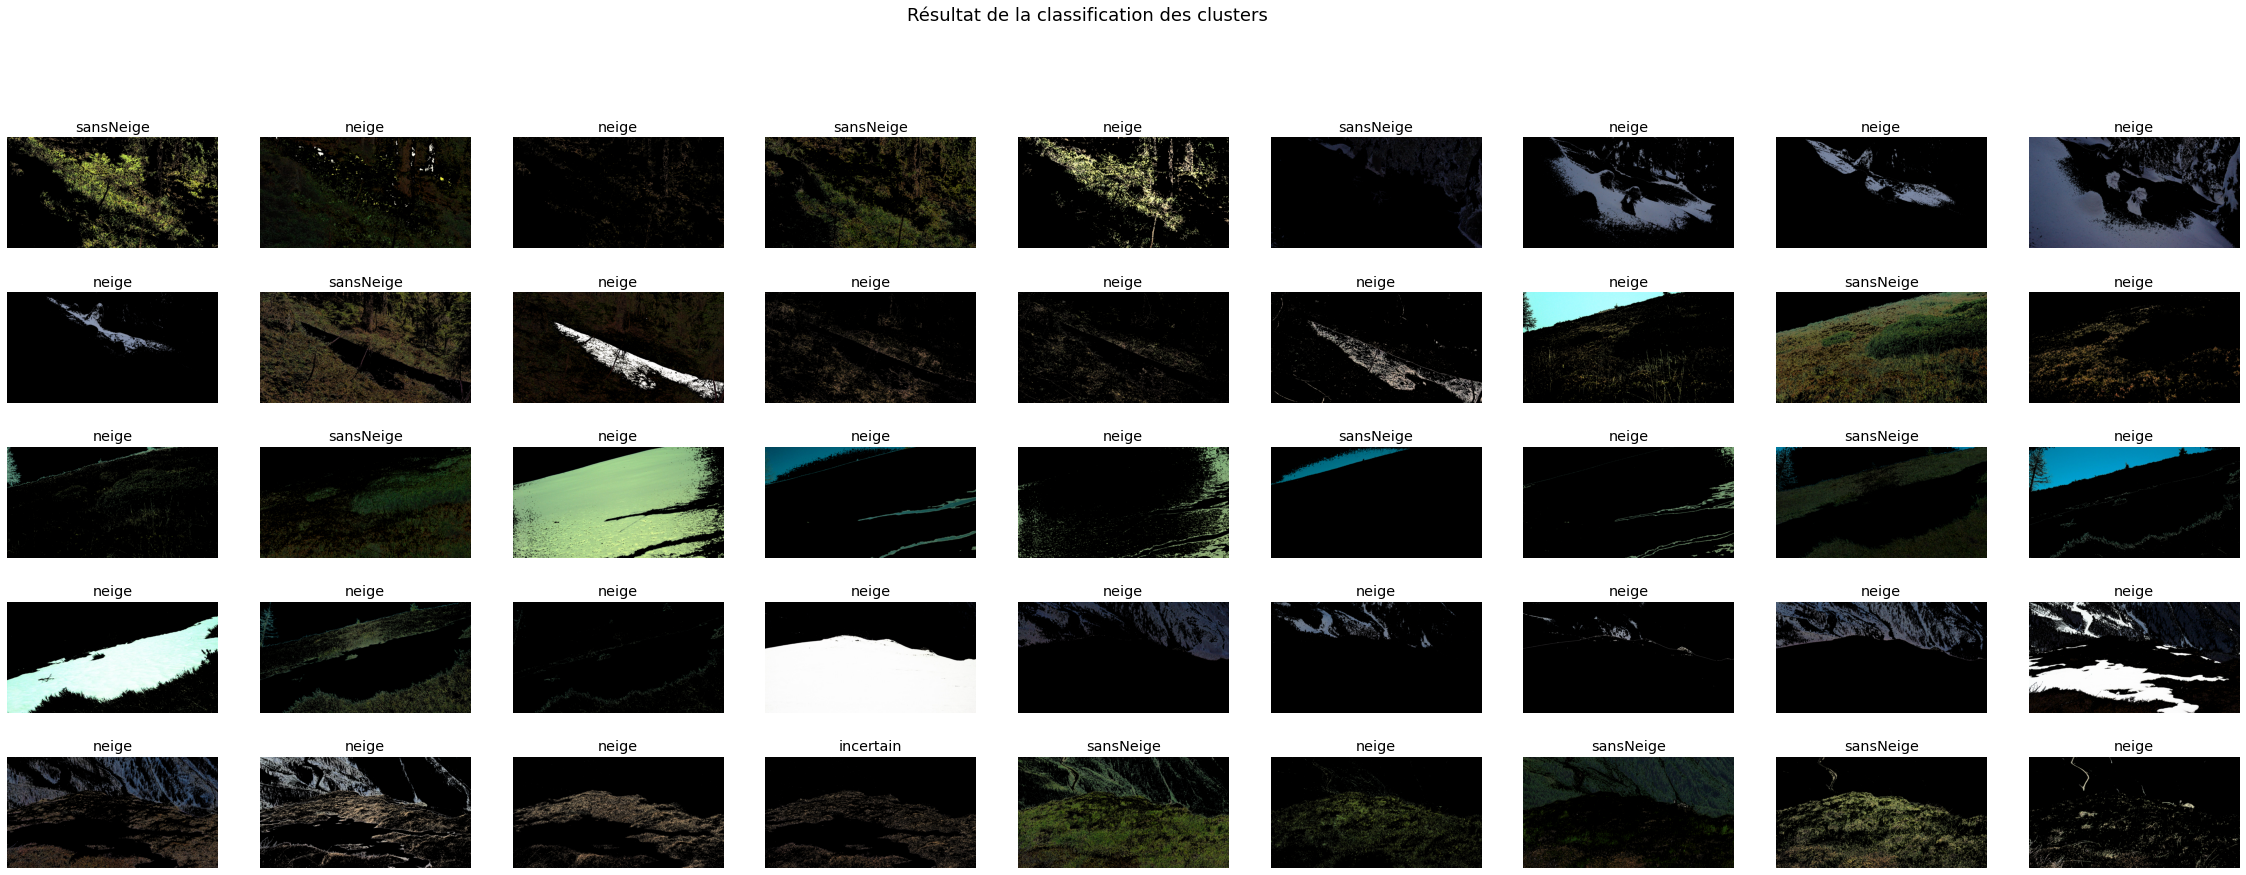

In [9]:
# récupération des labels du modèle de classification
labels = []
with open(dir + "/Modèles_trained/Classif_clusters/labels.txt", "r") as f:
    for line in f:
        labels.append(line.strip()[2:])
f.close()

print("liste des labels :", labels)

# chargement du moodèle de classification (entraîné sur des images de clusters)
model = load_model(dir + "/Modèles_trained/Classif_clusters/keras_model.h5")
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

#%%
def normalize(values):
    """retourne la liste en pourcentage"""
    res, somme = [], sum(values)
    for value in values:
        res.append(value*100/(somme))
    return res


plt.figure(figsize=(40, 25))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("Résultat de la classification des clusters", fontsize=18, y=0.95)

for n, img in enumerate(resultImgs):
    ax = plt.subplot(9, 9, n + 1)
    ax.imshow(img)
    # ax.set_title("test")
    width, height = len(img[0]), len(img)
    # img[i:i+100, j:j+100]
    # im_crop = im.crop((left, upper, right, lower))
    PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')
    size = (224, 224)
    resized = ImageOps.fit(PIL_image, size, Image.ANTIALIAS)
    image_array = np.asarray(resized)
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    data[0] = normalized_image_array

    # run the inference
    prediction = model.predict(data)
    prediction = prediction.tolist()[0]
    prediction = normalize(prediction)

    if max(prediction) > 90 and labels[np.argmax(prediction)] == "avecNeige":
        # print("neige")
        ax.set_title("neige")

    elif max(prediction) > 90 and labels[np.argmax(prediction)] == "sansNeige":
        # print("sansNeige")
        ax.set_title("sansNeige")

    else:
        ax.set_title("incertain")
        # print("incertain")
    ax.set_axis_off()
    
plt.show()

## 5. Segmentation

### Fonction de segmentation

In [12]:
# récupération des labels
def kMeans(img, n_clusters):
    """
    entrée: image à segmenter et nombre de classe à trouver
    sortie: masque de segmentation
    """
    def normalize(values):
        """retourne la liste en pourcentage"""
        res, somme = [], sum(values)
        for value in values:
            res.append(value*100/(somme))
        return res

    def image_to_pandas(image):
        """ met en fomre les données pour le kmeans"""
        df = pd.DataFrame([image[:,:,0].flatten(),
                        image[:,:,1].flatten(),
                        image[:,:,2].flatten()]).T
        df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
        return df

    # mise en forme des données 
    df_img = image_to_pandas(img)
    df_img.head(5)

    #application du K-means
    results = []

    kmeans = KMeans(n_clusters, random_state = 10).fit(df_img)

    result = kmeans.labels_.reshape(img.shape[0],img.shape[1])

    # récupération du modèle de reconnaissance
    labels = []
    with open(dir + "/Modèles_trained/Classif_clusters/labels.txt", "r") as f:
        for line in f:
            labels.append(line.strip()[2:])
    f.close()
    model = load_model(dir + '/Modèles_trained/Classif_clusters/keras_model.h5')
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    # attribution des clusters à la bonne classe
    """ découpe, prédiction, rangement """
    masques = []
    for i in range(n_clusters):
        tempImg = img.copy()
        tempImg[:, :, 0] = tempImg[:, :, 0]*(result==[i])
        tempImg[:, :, 1] = tempImg[:, :, 1]*(result==[i])
        tempImg[:, :, 2] = tempImg[:, :, 2]*(result==[i])
        # width, height = len(tempImg[0]), len(tempImg)
        PIL_image = Image.fromarray(np.uint8(tempImg)).convert('RGB')
        size = (224, 224)
        resized = ImageOps.fit(PIL_image, size, Image.ANTIALIAS)
        image_array = np.asarray(resized)
        normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
        data[0] = normalized_image_array

        # run the inference
        prediction = model.predict(data)
        prediction = prediction.tolist()[0]
        prediction = normalize(prediction)
        if max(prediction) > 90 and labels[np.argmax(prediction)] == "avecNeige":
            masques.append(result==[i])
    print("nombre de cluster(s) de neige:", len(masques))
    if len(masques) != 0:
        # regrouppement des clusters appartenant à la même classes
        segmentationMask = masques[0]
        for i in range(len(masques)):
            segmentationMask = masques[i] | segmentationMask
    else: 
        segmentationMask = np.full((1008, 1920), False)
    return segmentationMask

nombre de cluster(s) de neige: 3
nombre de cluster(s) de neige: 4
nombre de cluster(s) de neige: 4
nombre de cluster(s) de neige: 3
nombre de cluster(s) de neige: 4
nombre de cluster(s) de neige: 4
nombre de cluster(s) de neige: 5
nombre de cluster(s) de neige: 4
nombre de cluster(s) de neige: 2


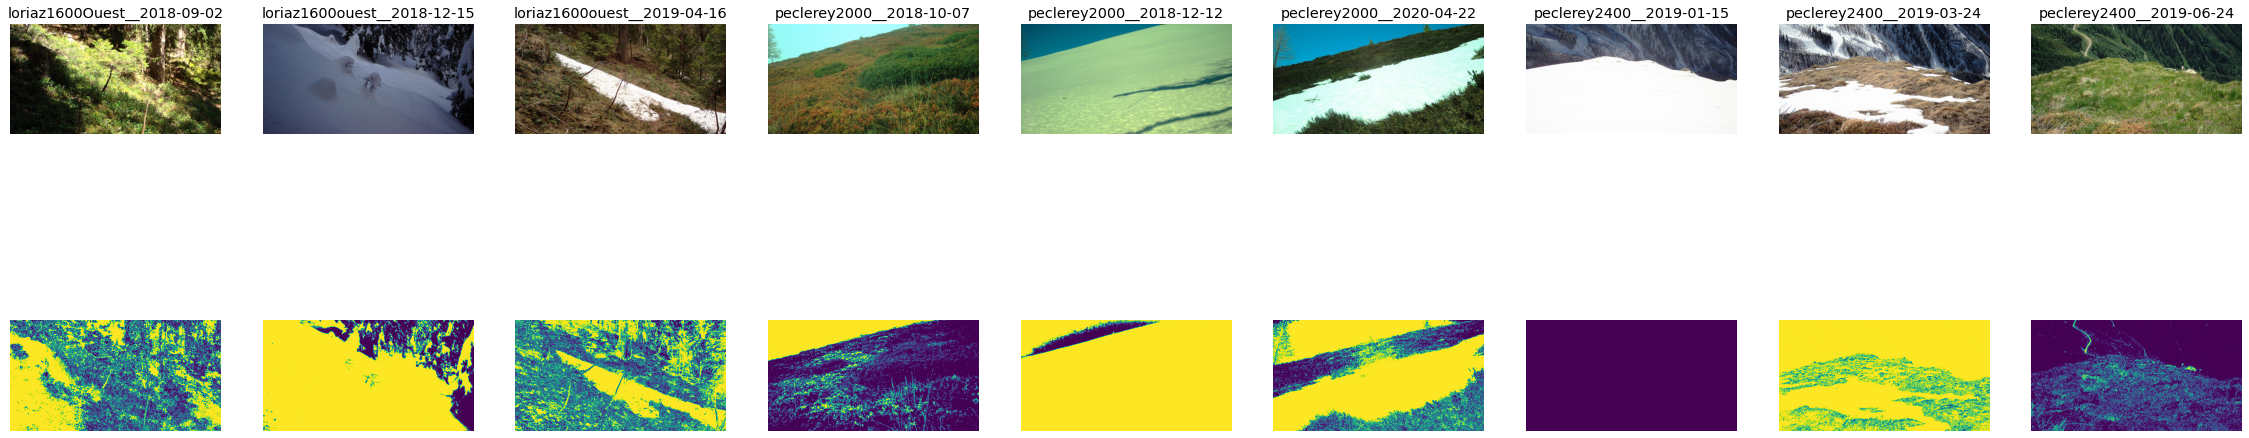

In [13]:
n = 5
fig, axs = plt.subplots(2, 9, figsize = (40, 10))
for i, img in enumerate(imgs):
    res = kMeans(img, 5)
    axs[0][i].imshow(img)
    axs[0][i].set_title(imgs_path[i][:-17])
    axs[0][i].set_axis_off()
    
    axs[1][i].imshow(res)
    axs[1][i].set_axis_off()

plt.show()

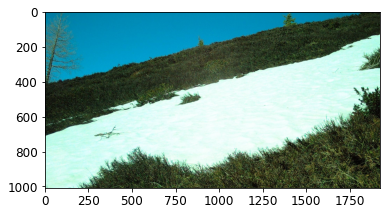

nombre de cluster(s) de neige: 4


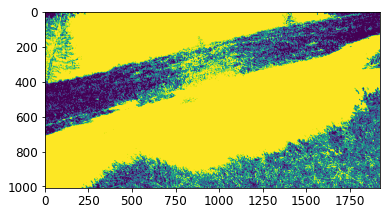

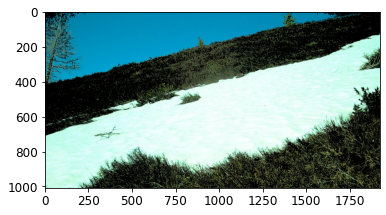

In [18]:
img = imgs[5]

plt.figure()
plt.imshow(img)
plt.show()

res = kMeans(img, 5)

plt.figure()
plt.imshow(res)
plt.show()

plt.figure()
tempImg = img.copy()
tempImg[:, :, 0] = tempImg[:, :, 0]*res
tempImg[:, :, 1] = tempImg[:, :, 1]*res
tempImg[:, :, 2] = tempImg[:, :, 2]*res
plt.imshow(tempImg)
plt.show()